In [1]:
import torch
import time

# init variable a,b as 1000 dimension vector
n=1000
a=torch.ones(n)
b=torch.ones(n)

In [2]:
# define a  timer class to record time
class Timer(object):
    """Record multiple running times."""
    def __init__(self):
        self.times=[]
        self.start()
   
    def start(self):
        # start the timer
        self.start_time=time.time()
        
    def stop(self):
        # stop the timer and record time into a list
        self.times.append(time.time()-self.start_time)
        return self.times[-1]
    
    def avg(self):
        # calculate the average and return
        return sum(self.times)/len(self.times)
    
    def sum(self):
        # return the sum of recorded time
        return sum(self.times)

向量加法的比较  
- 标量加法：按元素逐一相加
- 矢量加法：将两个向量直接做矢量加法  

首先将两个向量使用for循环按元素逐一做标量加法

In [3]:
timer=Timer()
c=torch.zeros(n)
for i in range(n):
    c[i]=a[i]+b[i]
"%.5f seconds"%timer.stop()

'0.02900 seconds'

然后使用torch直接对两个向量做矢量加法

In [4]:
timer.start()
d=a+b
"%.5f seconds"%timer.stop()

'0.00100 seconds'

# 线性回归模型从零开始的实现

In [6]:
# import packages and modules
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random
# jupyter :内嵌绘图
%matplotlib inline 

### 生成数据集
使用linear module生成数据集，1000个样本  

$$price=w_{area}*area+w_{age}*age+b$$


In [37]:
# 输入特征数量
NUM_INPUTS=2
# 样本数量
NUM_EXAMPELS=1000

#设置真实参数,权重矩阵W[]，偏置bias，用来生成数据集的真实标签
w=[2,-3.4]
b=4.2

features=torch.randn(NUM_EXAMPELS,NUM_INPUTS,dtype=torch.float32)
labels=w[0]*features[:,0]+w[1]*features[:,1]+b
# labels加入一点点噪声，噪声数据符合均值为0，宽度（标准差）为0.01的正态分布
labels+=torch.tensor(np.random.normal(0,0.01,size=labels.size()),dtype=torch.float32)

### 使用图像来展示生成的数据

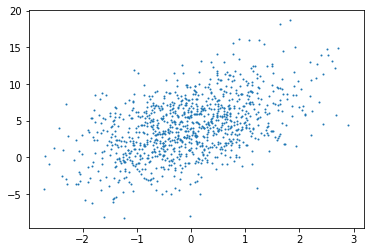

In [11]:
plt.scatter(features[:,0].numpy(),labels.numpy(),1)

### 读取数据集

In [38]:
def data_iter(batch_size,features,labels):
    num_examples=len(features)
    indices=list(range(num_examples))
    random.shuffle(indices) # 随机打算indices的顺序
    # i取值0~num_examples，步长为batch_size
    for i in range(0,num_examples,batch_size):
        # j每次取出一个batch_size的tensor，最后一次可能不够一个batch_size
        j=torch.LongTensor(indices[i:min(i+batch_size,num_examples)])
        # yield是一个生成器，index_select在指定维度取j指定的相应项返回新的tensor
        yield features.index_select(0,j),labels.index_select(0,j)

In [39]:
BATCH_SIZE=10

# for X,y in data_iter(batch_size,features,labels):
#     print(X,'\n',y)
#     break

### 初始化模型参数

In [40]:
# w_learn,b_learn是要通过训练学习的参数,在训练前先随机初始化
w_learn=torch.tensor(np.random.normal(0,0.01,(num_inputs,1)),dtype=torch.float32)
b_learn=torch.zeros(1,dtype=torch.float32)

w_learn.requires_grad_(requires_grad=True)
b_learn.requires_grad_(requires_grad=True)

w_learn,b_learn

(tensor([[ 0.0159],
         [-0.0008]], requires_grad=True),
 '\n',
 tensor([0.], requires_grad=True))

### 定义模型
定义用来训练参数的训练模型：  

$$price=w_{area}*area+w_{age}*age+b$$


In [41]:
def linearRegression(X,w,b):
    return torch.mm(X,w)+b # torch.mm 矩阵相乘

### 定义损失函数
使用均方误差损失函数：  

$$l^{(i)}(w,b)=\frac{1}{2}(\hat{y}^{(i)}-y^{(i)})^2$$  


In [42]:
def squared_loss(y_hat,y):
    return (y_hat-y.view(y_hat.size()))**2/2

### 定义优化函数
小批量随机梯度下降：  

$$(w,b)\leftarrow(w,b)-\frac{\eta}{|\beta|}\sum_{i\in\beta}\partial_{(w,b)}l^{(i)}(w,b)$$


In [43]:
def sgd(params,lr,batch_size):
    for param in params:
        param.data-=lr*param.grad/batch_size # 使用数据操作参数没有梯度跟踪

### 训练模型

In [44]:
# 超参数初始化
LR=0.03
NUM_EPOCHS=5

# 训练
for epoch in range(NUM_EPOCHS):
    # X是特征向量，y是标签，尺寸是一个batch_size
    for X,y in data_iter(batch_size,features,labels):
        y_hat=linearRegression(X,w_learn,b_learn)
        loss=squared_loss(y_hat,y).sum()
        loss.backward() # 计算批量样本损失的梯度
        sgd([w_learn,b_learn],LR,BATCH_SIZE) # 使用小批量随机梯度下降来迭代模型参数
        # 重置参数梯度
        w_learn.grad.data.zero_()
        b_learn.grad.data.zero_()
    train_loss=squared_loss(linearRegression(features,w_learn,b_learn),labels)
    print("epoch: {},loss: {}".format(epoch+1,train_loss.mean().item()))

epoch: 1,loss: 0.041578203439712524
epoch: 2,loss: 0.00015552206605207175
epoch: 3,loss: 4.943608655594289e-05
epoch: 4,loss: 4.8990626964950934e-05
epoch: 5,loss: 4.8957488615997136e-05


In [45]:
w,w_learn,b,b_learn

([2, -3.4], tensor([[ 2.0000],
         [-3.3999]], requires_grad=True), 4.2, tensor([4.2006], requires_grad=True))

# 线性回归模型使用PyTorch的简洁实现

In [127]:
import torch
from torch import nn
import numpy as np
torch.manual_seed(1) #每次初始化相同，使得实验可以复现

torch.set_default_tensor_type("torch.FloatTensor")

### 生成数据集

In [128]:
NUM_INPUTS=2
NUM_EXAMPLES=1000

W=[2,-3.4]
B=4.2

features=torch.tensor(np.random.normal(0,1,(NUM_EXAMPELS,NUM_INPUTS)),dtype=torch.float)
lables=W[0]*features[:,0]+W[1]*features[:,1]+B
lables+=torch.tensor(np.random.normal(0,0.01,size=lables.size()),dtype=torch.float)

### 读取数据集

In [142]:
import torch.utils.data as Data

BATCH_SIZE=10

# 组合数据集的特征和标签
dataset=Data.TensorDataset(features,labels)

# 将数据集放入dataloader
data_iter=Data.DataLoader(
    dataset=dataset,          # torch TensorDataset format
    batch_size=BATCH_SIZE,    # 批量大小
    shuffle=True,             # 是否打乱顺利
    num_workers=0,             # 多线程
)

In [49]:
for X,y in data_iter:
    print(X,'\n',y)
    break

tensor([[ 2.3894, -0.2153],
        [ 1.0667, -0.9417],
        [-0.1372, -0.0412],
        [ 0.9436,  2.0076],
        [-0.8629, -1.1596],
        [ 0.9843,  0.5790],
        [ 1.0678, -1.6272],
        [ 1.1646, -0.9377],
        [-0.9371,  0.9893],
        [ 1.1103,  1.8677]]) 
 tensor([-0.1295,  3.2085,  8.5177,  3.6092,  3.7359,  6.3555, -0.1464, 15.5801,
         5.2434, -2.2822])


# 定义模型

In [143]:
class LinearNet(nn.Module):
    def __init__(self,n_feature):
        super(LinearNet,self).__init__()  # 调用父类
        self.linear=nn.Linear(n_feature,1) # 线性回归模型结果输出一维的预测值，原型torch.nnLinear(in_features,out_features,bias=True)
        
    def forward(self,x):
        y=self.linear(x)
        return y

net=LinearNet(NUM_INPUTS)
# print(net[0])

初始化多层网络的3种方法  
- 方法1  
```python
net=nn.Sequential(nn.Linear(NUM_INPUTS,1)
                  # 其他层可以在这里添加
                 )
```
- 方法2  
```python
net=nn.Sequential()
net.add_module('linear',nn.Linear(NUM_INPUTS,1))
#net.add_module......
```
- 方法3  
```python
from collections import OrderedDict
net=nn.Sequential(OrderedDict([
    ('linear',nn.Linear(NUM_INPUTS,1))
    #......
]))
```

In [157]:
# method one
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # other layers can be added here
    )

print(net)
print(net[0])

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


### 初始化模型参数

In [158]:
from torch.nn import init

init.normal_(net[0].weight,mean=0.0,std=0.01) #n维的torch.Tensor,正态分布的均值，标准差
init.constant_(net[0].bias,val=0.0) #n维的torch.Tensor，用来填充的张量

Parameter containing:
tensor([0.], requires_grad=True)

In [106]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.0034,  0.0019]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


### 定义损失函数

In [159]:
loss=nn.MSELoss()

### 定义优化函数

In [160]:
import torch.optim as optim

optimizer=optim.SGD(net.parameters(),lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


### 训练

In [161]:
NUM_EPOCHS=10
for epoch in range(NUM_EPOCHS):
    for X,y in data_iter:
        y_hat=net(X)
        loss_f=loss(y_hat,y.view(-1,1))
        optimizer.zero_grad()
        loss_f.backward()
        optimizer.step()
        
    print("epoch:{},loss:{}".format(epoch+1,loss_f.item()))

epoch:1,loss:7.436114311218262
epoch:2,loss:6.9896955490112305
epoch:3,loss:21.924951553344727
epoch:4,loss:11.167420387268066
epoch:5,loss:14.600977897644043
epoch:6,loss:11.437329292297363
epoch:7,loss:10.282097816467285
epoch:8,loss:11.784852981567383
epoch:9,loss:8.335785865783691
epoch:10,loss:12.937174797058105


In [156]:
dense=net[0]
print(W,dense.weight.data)
print(B,dense.bias.data)

[2, -3.4] tensor([[-0.0845,  0.1310]])
4.2 tensor([4.5577])
